# Solving LunarLander-v2 with Tabular, Deep-Q Network and Policy Gradient Methods (DQN section)
*  ## Group members:
   *  Mengyang Liu
   *  Xiaoyao Guo
   *  Yanan Wang

## Table of Content: <a class="anchor" id="TOC"></a>
* This table of content only works for offline.
* If this is opened on Colab, consider the generated table of content on the left.

<br>

### [Initialize and Setting up Environment](#ENV)
* [Initialization](#init)

<br>

### [Deep-Q Network](#DQN)
* [Update rule in DQN](#update)
* [DQN Pseudo-code](#code)
* [Static hyperparameters](#static)
* [DQN class](#class)
* [Grid Search](#grid)
* [Setting up and train DQN](#train)

<br>

### [Results](#Result)
* [Visualization of the resulting model](#visual)
* [Compare performances between DQN in different training period](#clips)

<br>

### [Conclusion](#conc)

## Initialize and Setting up Environment  <a class="anchor" id="ENV"></a>

<br>

*   [To Table of Contents](#TOC)

### Initialization <a class="anchor" id="init"></a>
*  TensorFlow is used as our deep learning library.
*  One custom packages are used:
   *  **"custom_animation.py"**: we only use method `animate_one_episode(env, policy)` to play one episode of LunarLander by the given policy and show the animation.
      *  Require `matplotlib` and `opencv-python`.

In [1]:
%matplotlib notebook
import numpy as np
import gym
import tensorflow as tf

# Ignore deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualization
from IPython.display import HTML
import matplotlib.pyplot as plt

# If running on Colab, we need to specify the path of this notebook
import sys
if "google.colab" in sys.modules:
    # Set this to the directory of this file in Google Drive
    notebook_path = '/content/drive/MyDrive/CISC 474/code' 
    sys.path.append(notebook_path)
    sys.path.append(notebook_path+'/models')
    sys.path.append(notebook_path+'/models/clips')
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = notebook_path
else:
    root_path = '.'
    
# Custom package
import custom_animation as ani

Mounted at /content/drive


*  See if GPU is available

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


*   Run the following code if not on Colab for visualization.

In [ ]:
pip install opencv-python

*  Set up LunarLander-v2 environment.

In [3]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 27.7 MB/s 
     |████████████████████████████████| 374 kB 73.0 MB/s 
     |████████████████████████████████| 1.8 MB 61.8 MB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [4]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)

*   A function to plot learning curves.

In [5]:
def plot_learning_curve(epoch_lists, epoch_size = 100, legend = None, title = None, x_label = "episodes", y_label = "avg reward per epoch", size = 1):
    for i in range(len(epoch_lists)):
        x = [(j+1)*epoch_size for j in range(len(epoch_lists[i]))]
        if not legend:
            plt.plot(x, epoch_lists[i])
        else:
            plt.plot(x, epoch_lists[i], label = legend[i])
            
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title("Learning curves for each training episode", fontsize=17)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.figure(figsize=[size*6.4, size*4.8])

*  **Allow displaying figures in Colab.**
   *  Run this after the animation for cleaner outputs.

In [6]:
if "google.colab" in sys.modules:
  %matplotlib inline

## Deep-Q Network

<br>

*   [To Table of Contents](#TOC)

### Update rule in DQN <a class="anchor" id="update"></a>
*   From slides: 
   *   $\vec{w}\leftarrow \vec{w} + \alpha [R_{t+1}+\gamma Q(S_{t+1},A_{t+1},\vec{w})-Q(S_t, A_t, \vec{w})]\nabla Q(s, a, \vec{w})$
*   To be more specific:
   *   $\vec{w}\leftarrow \vec{w} + \alpha [R_{t+1}+\gamma Q_{\text{target}}(S_{t+1},A_{t+1})-Q_{\text{online}}(S_t, A_t, \vec{w})]\frac{\partial}{\partial \vec{w}} Q_{\text{online}}(S_t, A_t, \vec{w})$
   *   $\vec{w}\leftarrow \vec{w} - \alpha \frac{\partial}{\partial \vec{w}}\frac{1}{2}[R_{t+1}+\gamma Q_{\text{target}}(S_{t+1},A_{t+1})-Q_{\text{online}}(S_t, A_t, \vec{w})]^2$
*   Stochastic Gradient Descent usually takes in the form:
   *   $\vec{w}\leftarrow \vec{w} - \alpha\frac{\partial}{\partial \vec{w}}\mathrm{loss}[\text{label}-\text{prediction}(\vec{w})]$
*   We define target Q-value(seen in other literature) as the following:
   *   $y(S_t,A_t)=R_{t+1}+\gamma Q_{\text{target}}(S_{t+1},A_{t+1})$
*   In Q-learning, we use $\underset{a}{\mathrm{max}}\ Q_{\text{target}}(S_{t+1},a)$ instead of $Q_{\text{target}}(S_{t+1},A_{t+1})$.
   *   $y(S_t,A_t)=R_{t+1}+\gamma \underset{a}{\mathrm{max}}\ Q_{\text{target}}(S_{t+1},a)$
*   Now the update rule can be written as:
   *   $\vec{w}\leftarrow \vec{w} - \alpha\frac{\partial}{\partial \vec{w}}\mathrm{loss}[y(S_t,A_t)-Q_{\text{online}}(S_t, A_t, \vec{w})]$
   *   where we substitude $\text{label}=y(S_t,A_t)$ and $\text{prediction}(\vec{w})=Q_{\text{online}}(S_t, A_t, \vec{w})$
   *   If we select $\text{loss}(x)=\frac{1}{2}x^2$, we get the same update rule in the slides.

<br>

*   Different from tabular methods, in DQN, the Q-values of all actions in each state are updated.

### DQN Pseudo-code <a class="anchor" id="code"></a>
* Initialize:
  * ReplayBuffer
  * $Q_{\text{online}}(S,A,\vec{w})$, $Q_{\text{target}}(S,A)$
* Loop forever(for each episode)
  * Loop for each step of episode:
    * Select action $A$ by $\varepsilon$-greedy in state $S$
    * Execute $A$ and observe $R$, $S'$
    * Add $(S,A,R,S')$ to ReplayBuffer
    * $S\leftarrow S'$
    * For every some timesteps, if ReplayBuffer.size()>$\mathrm{Batchsize}$:
      * Repeat $\mathrm{Batchsize}$ times:
        * Sample $(S,A,R,S')$ from ReplayBuffer
        * $y(S_t,A_t)=R_{t+1}+\gamma \underset{a}{\mathrm{max}}\ Q_{\text{target}}(S_{t+1},a)$
        * $\vec{w}\leftarrow \vec{w} - \alpha\frac{\partial}{\partial \vec{w}}\mathrm{loss}[y(S_t,A_t)-Q_{\text{online}}(S_t, A_t, \vec{w})]$
  * For every some episode, $Q_{\text{target}}(\cdot, \cdot)=Q_{\text{online}}(\cdot, \cdot, \vec{w})$

### Static hyperparameters <a class="anchor" id="static"></a>
*  Since there are too many hyperparameters to fine-tune, we keep some of them static and tune others.
*  Below are some of the hyperparameters we keep them unchanged:
  *  `GAMMA`: decaying factor $\gamma$
  *  `MAX_LENGTH`: maximum length of the replay buffer.
  *  `WEIGHT_UPDATE`: timesteps to update weights.
  *  `TARGET_UPDATE`: episodes to update target network.
  *  `BATCH_SIZE`: sampled timestep from replay buffer for update.
*  Other unchanged hyperparameters that are not shown here:
  *  Minimum exploration: $0.01$
  *  Maximum timesteps in each episode: $200$

In [7]:
GAMMA = 0.99
MAX_LENGTH = 100000
WEIGHT_UPDATE = 4
TARGET_UPDATE = 4
BATCH_SIZE = 128

### DQN class <a class="anchor" id="class"></a>

In [8]:
from collections import deque

class DQN:

    def __init__(self, online_model, action_num, epsilon = 0.01, gamma = GAMMA):
        self.action_num = action_num
        self.online_model = online_model
        self.target_model = tf.keras.models.clone_model(self.online_model)
        self.target_model.set_weights(self.online_model.get_weights())

        # Discount factor
        self.gamma = gamma

        # Function to choose for exploration
        # Invoked by several functions so we define in initialization
        if (isinstance(epsilon, (int, float))):
            # Constant epsilon
            eps = epsilon
            epsilon = lambda x : eps
        self.epsilon = epsilon

        # Double-ended queue allow removing/adding elements on both ends.
        # This allows the sampling to be more effiecient.

        # Each instance in the queue is a (S, A, R, S', done) at a time step
        self.replay_buffer = deque(maxlen=MAX_LENGTH)
    
    # Given a model and observation of the state, return the predicted action
    def predict(self, obs, model=None):
        # Default choice of model is the online one
        if not model:
            model = self.online_model
        return model.predict(obs[np.newaxis],verbose=0)[0].argmax()

    # Epsilon-greedy
    # t: episode number, used to decrease epsilon
    def egreedy(self, state, t):
        if np.random.random() > self.epsilon(t):
            return self.predict(state, self.online_model)
        else:
            return np.random.randint(self.action_num)
  
    # Choose and execute an action, then add it to the replay buffer.
    def step(self, env, state, t):
        # Choose and execute an action
        action = self.egreedy(state, t)
        next_state, reward, done, info = env.step(action)
        # Append (S, A, R, S', done) to the buffer for sampling.
        self.replay_buffer.append((state, action, reward, next_state, done))
        # return R, S', done, info for choosing actions at the next step
        return next_state, reward, done, info

    # Sample experiences from the replay buffer.
    # batch_size: number of timesteps to sample
    def sample_experiences(self, batch_size):
        # Randomly select indices to sample
        indices = np.random.choice(len(self.replay_buffer), batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        # Dispatch S, A, R, S', done from batch for easier indexing
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)
        ]
        return states, actions, rewards, next_states, dones

    # Sample experiences and then apply update rule
    def update(self, batch_size, optimizer, loss_fn):
        # Sample a batch of information from the buffer
        states, actions, rewards, next_states, dones = self.sample_experiences(batch_size)
    
        # Apply update rule

        next_Q_values = self.target_model.predict(next_states, verbose=0)
        max_next_Q_values = next_Q_values.max(axis=1)

        # target Q-values
        # At non-terminal states, y(S,A) = R + gamma * max_a Q_target(S',a)
        # At terminal states, we do not have the next timestep. Thus, y(S,A) = R
        target_Q_values = rewards + self.gamma * max_next_Q_values * (1 - dones)

        # Reshape to a column, so that (target Q-values - Q_values) will be easier to compute
        target_Q_values = target_Q_values.reshape(-1, 1)

        # One-hot encode the actions at each state in the timestep
        one_hot = tf.one_hot(actions, self.action_num)

        # Use tf.GradientTape() to gain more low-level control over the update
        # In DQN, the "labels" are generated as timestep proceeds.
        with tf.GradientTape() as tape:
            # Q_online(S,A)

            # Calculate on all Q-values in the states for each action.
            all_Q_values = self.online_model(states)
            Q_values = tf.reduce_sum(all_Q_values * one_hot, axis=1, keepdims=True)

            # Compute loss
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

        # Take gradient of loss and update
        grads = tape.gradient(loss, self.online_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.online_model.trainable_variables))

    # Train the DQN
    # Step 1: DQN plays for some steps(no learning), using step()
    # Step 2: DQN learns from previous experiences by update()
    # Step 3: DQN continue playing for some steps.
    # Step 4: repeat Step 2, 3 in each episode.
    # Step 5: At the end of every some episodes, 
    # clone the target model from the online model.

    # batch_size: number of timesteps sampled for update
    # optimizer: the optimization algorithm used for DQN
    # loss_fn: the loss function used for DQN
    # epoch_size: number of episodes to clone the target network
    #        also the number of episodes to report
    # max_episodes: training will stop if it is reached
    # max_steps: maximum numbers of timesteps allowed in each episodes.
    #       200 is selected to be specific to Lunarlander.
    # verbose: True to print report

    def train(self, env, batch_size, optimizer, loss_fn, epoch_size=100, max_episodes=5000, max_steps=200, verbose=False):
        # Below for report
        episode_step_list = []
        episode_reward_list = []
        epoch_step = 0
        epoch_reward = 0
        episode_step = 0
        episode_reward = 0
        prev_reward = 0

        #To select the best model
        best_reward = 0
        best_weights = self.online_model.get_weights()

        # Start training
        for episode in range(max_episodes):
            # New episode begins
            state = env.reset()
            # Terminate this episode if max_steps is reached
            for time_step in range(max_steps):
                state, reward, done, info = self.step(env, state, episode)

                epoch_step += 1
                episode_step += 1
                epoch_reward += reward
                episode_reward += reward

                # Update policy
                if (len(self.replay_buffer) > batch_size and time_step % WEIGHT_UPDATE == 0):
                    self.update(batch_size, optimizer, loss_fn)
                if done: break
            # 1 episode is finished

            # See if best weights need to update
            if episode_reward >= best_reward:
                best_reward = episode_reward
                best_weights = self.online_model.get_weights()



            episode_step_list.append(episode_step)
            episode_reward_list.append(episode_reward)
            episode_step = 0
            episode_reward = 0


            # 1 epoch is finished if the following is satisfied
            if ((episode+1)% epoch_size) == 0:
                epoch_step = epoch_step / epoch_size
                epoch_reward = epoch_reward / epoch_size
        
                if verbose:
                    print("episode: %d, avg episode steps: %.4f, avg episode reward: %.4f, abs reward diff: %.4f" 
                          % (episode+1, epoch_step, epoch_reward, abs(epoch_reward-prev_reward))) 
        
                prev_reward = epoch_reward
                epoch_step = 0
                epoch_reward = 0


            if ((episode+1) % TARGET_UPDATE) == 0:
                # Update the target model
                self.target_model.set_weights(self.online_model.get_weights())

            # Save a clip of model
            # if ((episode+1) % 200) == 0:
            #     # Later moved to other paths
            #     self.online_model.save("./ffdqn_"+str(episode+1)+".h5")
    
        self.online_model.set_weights(best_weights)

        return episode_step_list, episode_reward_list

### Grid Search <a class="anchor" id="grid"></a>
*   Decay factors: $[0.995, 0.999]$
*   Learning rates: $[0.01, 0.001, 0.0001]$

In [ ]:
def grid_search(decays, alphas, env, batch_size=BATCH_SIZE, epoch_size=100, max_episodes=400, max_steps=200):
    step_lists = []
    reward_lists = []
    for decay in decays:
        for alpha in alphas:
            epsilon = lambda x : max(0.01, 1*(decay**x))
            
            input_shape = env.observation_space.shape
            action_num = env.action_space.n
            
            loss_fn = tf.keras.losses.mean_squared_error
            optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
            
            online_model = tf.keras.Sequential([
                tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(action_num)
            ])
            
            ffdqn = DQN(online_model, action_num, epsilon=epsilon)
            episode_step_list, episode_reward_list = ffdqn.train(env=env, 
                                                                 batch_size=BATCH_SIZE,
                                                                 optimizer=optimizer, 
                                                                 loss_fn=loss_fn, 
                                                                 epoch_size=epoch_size, 
                                                                 max_episodes=max_episodes, 
                                                                 max_steps=max_steps, 
                                                                 verbose=True)
            step_lists.append(episode_step_list)
            reward_lists.append(episode_reward_list)
            print("Done")
            
    return step_lists, reward_lists

In [ ]:
decays = [0.995, 0.999]
alphas = [0.01, 0.001, 0.0001]

legends = []
for i in range(len(decays)):
    for j in range(len(alphas)):
        legends.append("d="+str(decays[i])+", a="+str(alphas[j]))

step_lists, reward_lists = grid_search(decays, alphas, env)

episode: 100, avg episode steps: 108.2400, avg episode reward: -141.3612, abs reward diff: 141.3612
episode: 200, avg episode steps: 120.1200, avg episode reward: -73.8054, abs reward diff: 67.5558
episode: 300, avg episode steps: 159.9600, avg episode reward: -19.6973, abs reward diff: 54.1081
episode: 400, avg episode steps: 198.7000, avg episode reward: 71.9843, abs reward diff: 91.6815
Done
episode: 100, avg episode steps: 104.2600, avg episode reward: -113.3093, abs reward diff: 113.3093
episode: 200, avg episode steps: 161.7700, avg episode reward: 11.1191, abs reward diff: 124.4284
episode: 300, avg episode steps: 194.3000, avg episode reward: 66.9174, abs reward diff: 55.7982
episode: 400, avg episode steps: 199.8800, avg episode reward: 83.6243, abs reward diff: 16.7070
Done
episode: 100, avg episode steps: 118.2800, avg episode reward: -168.5638, abs reward diff: 168.5638
episode: 200, avg episode steps: 168.1200, avg episode reward: -39.6606, abs reward diff: 128.9032
episod

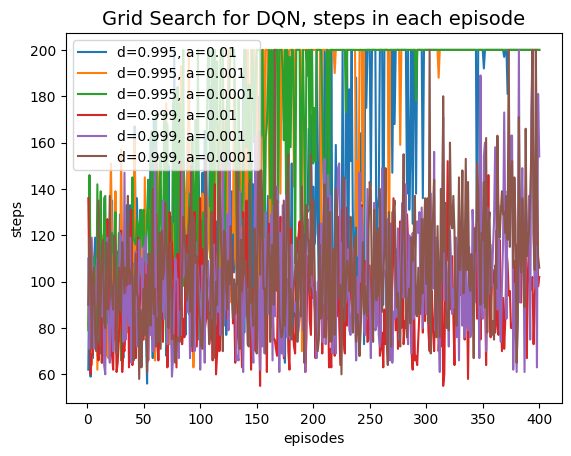

<Figure size 3200x2400 with 0 Axes>

In [ ]:
%matplotlib inline
plot_learning_curve(step_lists, epoch_size = 1, legend = legends, title = "Grid Search for DQN, steps in each episode", 
          x_label = "episodes", y_label = "steps", size = 5)

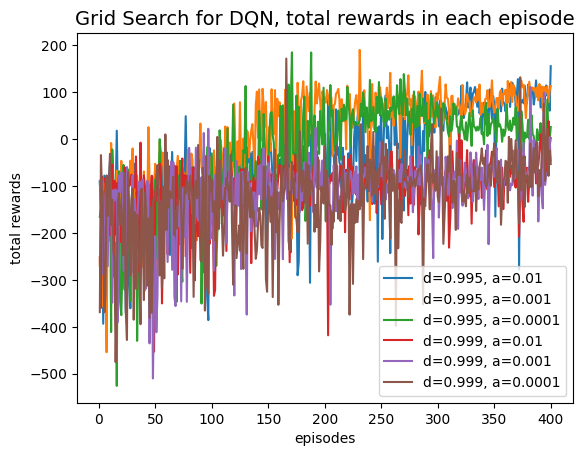

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_learning_curve(reward_lists, epoch_size = 1, legend = legends, title = "Grid Search for DQN, total rewards in each episode", 
          x_label = "episodes", y_label = "total rewards", size = 1)

### Setting up and train DQN <a class="anchor" id="train"></a>

In [ ]:
input_shape = env.observation_space.shape #[8]
action_num = env.action_space.n #4

online_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(action_num)
    # Linear activation since we are approximating Q-values
])

In [ ]:
epsilon = lambda x : max(0.01, 1*(0.995**x))
ffdqn = DQN(online_model, action_num, epsilon=epsilon)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.mean_squared_error
#optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
#loss_fn = tf.keras.losses.mean_squared_error

tf.debugging.set_log_device_placement(True)
episode_step_list, episode_reward_list = ffdqn.train(env=env, batch_size=BATCH_SIZE, optimizer=optimizer, loss_fn=loss_fn, epoch_size=100, max_episodes=1800, max_steps=200, verbose=True)

episode: 100, avg episode steps: 107.0300, avg episode reward: -125.8135, abs reward diff: 125.8135
episode: 200, avg episode steps: 149.3500, avg episode reward: -7.8360, abs reward diff: 117.9774
episode: 300, avg episode steps: 184.8000, avg episode reward: 31.2063, abs reward diff: 39.0424
episode: 400, avg episode steps: 197.4400, avg episode reward: 70.8061, abs reward diff: 39.5998
episode: 500, avg episode steps: 200.0000, avg episode reward: 84.5866, abs reward diff: 13.7805
episode: 600, avg episode steps: 199.1800, avg episode reward: 92.3336, abs reward diff: 7.7469
episode: 700, avg episode steps: 200.0000, avg episode reward: 107.7450, abs reward diff: 15.4115
episode: 800, avg episode steps: 200.0000, avg episode reward: 105.3130, abs reward diff: 2.4320
episode: 900, avg episode steps: 200.0000, avg episode reward: 99.3585, abs reward diff: 5.9545
episode: 1000, avg episode steps: 199.4200, avg episode reward: 106.0438, abs reward diff: 6.6852
episode: 1100, avg episode

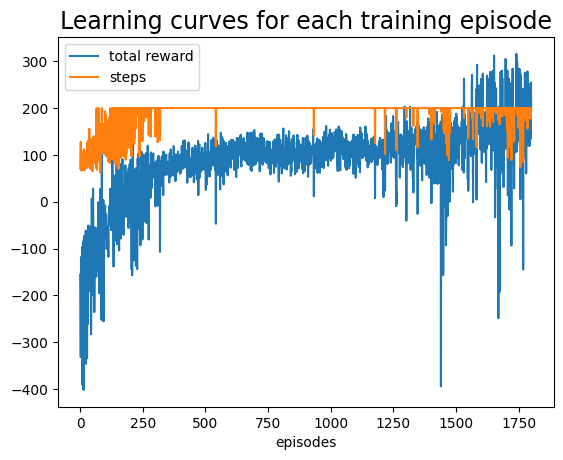

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_learning_curve([episode_reward_list, episode_step_list], epoch_size = 1, legend = ["total reward", "steps"], title = None, x_label = "episodes", y_label = "", size = 1)

In [ ]:
ffdqn.online_model.save("./ffdqn_1800_best.h5")

## Results

<br>

*   [To Table of Contents](#TOC)

### Visualization of the resulting model <a class="anchor" id="visual"></a>

In [9]:
class Demo:
    def __init__(self, model):
        self.model = model
    def predict(self, obs):
        return self.model.predict(obs[np.newaxis],verbose=0)[0].argmax()

*  Best model in 1800 episodes training:

In [ ]:
best_1800 = Demo(tf.keras.models.load_model(root_path+'/models/ffdqn_1800_best.h5'))
anim = ani.animate_one_episode(env, best_1800)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

*   Best model in 1600 episodes training:

In [ ]:
best_1600 = Demo(tf.keras.models.load_model(root_path+'/models/ffdqn_1600_best.h5'))
anim = ani.animate_one_episode(env, best_1600)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

### Compare performances between DQN in different training period <a class="anchor" id="clips"></a>

In [10]:
def multiple_models(dqns, env, max_steps=400, seed=40):
    total_reward_lists = []
    for dqn in dqns:
        env.seed(seed)
        state = env.reset()
        total_rewards = []
        total_reward = 0
        for t in range(max_steps):
            action =dqn.predict(state)
            state, reward, done, info = env.step(action)
            
            total_reward += reward
            total_rewards.append(total_reward)
            
            if done: break
        print("Done")
        total_reward_lists.append(total_rewards)
    return total_reward_lists

In [11]:
dqn_list = []
chosen_episode = ["200", "400", "1200", "1400", "1600", "1800"]
for epi_num in chosen_episode:
    file_name = root_path + "/models/clips/ffdqn_" + epi_num + ".h5"
    ffdqn = Demo(tf.keras.models.load_model(file_name))
    dqn_list.append(ffdqn)

In [15]:
dqn_reward_lists = multiple_models(dqn_list, env, max_steps=400, seed=40)

Done
Done
Done
Done
Done
Done


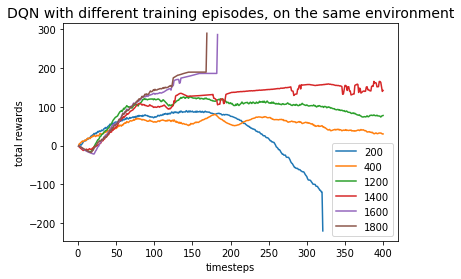

<Figure size 460.8x345.6 with 0 Axes>

In [16]:
plot_learning_curve(dqn_reward_lists, epoch_size = 1, legend = chosen_episode, title = "DQN with different training episodes, on the same environment", 
          x_label = "timesteps", y_label = "total rewards", size = 1)

## Conclusion <a class="anchor" id="conc"></a>

<br>

*   [To Table of Contents](#TOC)

*  DQN solves the no wind environment successfully at about 1600 episode training.
*  Starting from episode 1600, the model tries to land as fast as possible, which causes instabilities as well.